# Machine Learning with Spark (15 points)

**Read through the entire workbook before beginning work to familiarize with what is being asked.**

In this exericise, you will work with a fairly large dataset and do some modeling and predictions using Spark Machine Learning. The dataset being used is the 2013 NYC Taxi Dataset [https://archive.org/details/nycTaxiTripData2013](https://archive.org/details/nycTaxiTripData2013). The original dataset consists of two files, `trip_data` and `trip_fare`, which need to be merged to create the dataset for modeling. 

The merge has already been performed and stored as a parquet file on S3 because there were some data issues that were not covered in class. The workbook [merge-fare-and-trip-data-create-parquet.ipynb](merge-fare-and-trip-data-create-parquet.ipynb) contains code for creating the merged set (for reference.)

This is an interactive PySpark session. Remember that when you open this notebook the SparkContext and SparkSession are already created, and they are in the sc and spark variables, respectively. You can run the following two cells to make sure that the Kernel is active.

**Do not insert any additional cells than the ones that are provided for assignment submission. You may add cells as you work through the notebook, but you need to delete extra cells and keep the initial structure.**

### Note on time it takes to complete the model training

When we designed the assignment, it was thoroughly tested and the training time took no more than 30-40 mins with the provided configuration on the entire dataset. In previous courses, several students told us that the training is taking too long, more than that. There is no direct way to troubleshoot. That is one of the unfortunate realities with working with these tools.

If you do run into problems, you have two options:

- Try adding more core or task nodes to the cluster, and restart your notebook and try again.
- Your other option is  to take a 10% sample of the "encoded_dataset" before you split into 90% training and 10% testing. 

### Some suggestions you may want to follow:

* You may consider saving intermediate datasets (i.e. training and testing) when you first create them. To save intermediate datasets, save them as **parquet** files in your own S3 bucket. To save, use the following code: `df.write.parquet("s3://[[your-s3-bucket]]/data_location/", mode="overwrite")`.
* You may also want to save a model object in S3 after you train it, especially if training takes a while. To save a model object, use the following code: `model.save("s3://[[your-s3-bucket]]/model_location/")`
* When creating the Machine Learning pipelines, you may want to try it first on a minuscule sample of your training data to make sure the pipelines work as planned. To create a tiny DataFrame, use the `limit` method: `df.limit(100)` (this creates a small DataFrame with the first 100 rows from df.)

In [1]:
sc

<SparkContext master=yarn appName=PySparkShell>

In [2]:
spark

## Import necessary libraries

The following cell will load all required libraries and functions for this exercise.

In [3]:
from pyspark.sql.functions import UserDefinedFunction
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorIndexer
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import functions
from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.feature import RFormula
import matplotlib.pyplot as plt
import numpy as np
import datetime

## Part 1 - Load the data, convert data types and create new features (5 points)

### Load the data

In the following cell, create an object called `nyctaxi` which loads the **parquet** files from `s3://bigdatateaching/nyctaxi-2013/merged-parquet/`.

This step took approximately 8 seconds during the development of the workbook using the cluster configuration in the assignment. The workbook will have spots were running times during development are written for reference as a comment in a cell. Your run times may vary, but these values will give you an indication.

In [4]:
# ~ 8 seconds
nyctaxi = spark.read\
  .format('parquet')\
  .option('header', 'true')\
  .option('inferSchema', 'true')\
  .load('s3://bigdatateaching/nyctaxi-2013/merged-parquet/')

In the next cell print the schema of `nyctaxi`.

In [5]:
nyctaxi.printSchema()


root
 |-- medallion: string (nullable = true)
 |-- hack_license: string (nullable = true)
 |-- vendor_id: string (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: string (nullable = true)
 |-- surcharge: string (nullable = true)
 |-- mta_tax: string (nullable = true)
 |-- tip_amount: string (nullable = true)
 |-- tolls_amount: string (nullable = true)
 |-- total: string (nullable = true)
 |-- rate_code: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- dropoff_datetime: string (nullable = true)
 |-- passenger_count: string (nullable = true)
 |-- trip_time_in_secs: string (nullable = true)
 |-- trip_distance: string (nullable = true)
 |-- pickup_longitude: string (nullable = true)
 |-- pickup_latitude: string (nullable = true)
 |-- dropoff_longitude: string (nullable = true)
 |-- dropoff_latitude: string (nullable = true)



In the next cell, count the number of records for `nyctaxi`.

In [6]:
# ~ 12 seconds
nyctaxi.count()

173185091

In the next cell, show the first 10 records of `nyctaxi` to see what the data looks like.

In [7]:
# ~ 4 seconds
nyctaxi.show(10)

+--------------------+--------------------+---------+-------------------+------------+-----------+---------+-------+----------+------------+-----+---------+------------------+-------------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+
|           medallion|        hack_license|vendor_id|    pickup_datetime|payment_type|fare_amount|surcharge|mta_tax|tip_amount|tolls_amount|total|rate_code|store_and_fwd_flag|   dropoff_datetime|passenger_count|trip_time_in_secs|trip_distance|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|
+--------------------+--------------------+---------+-------------------+------------+-----------+---------+-------+----------+------------+-----+---------+------------------+-------------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+
|00005007A9F30E289...|132A7AC13C8471488...|      CMT|2013-07-30 

### Convert data types

As you can see from printing the `nyctaxi` schema, all of the fields were loaded as strings. This will not work for modeling purposes. You need to convert some of the fields to other types. In the following cell, create a new DataFrame called `nyctaxi_converted` and use the `withColumn` method to do the following conversions:

 Field Name | Type
------------|-----
trip_time_in_seconds | integer
trip_distance | float
pickup_latitude | float
pickup_longitude | float
dropoff_latitude | float
dropoff_longitude | float
fare_amount | float
surcharge | float
mta_tax | float
tip_amount | float
tolls_amount | float
total | float
pickup_datetime | timestamp
dropoff_datetime | timestamp




In [8]:
nyctaxi_converted=nyctaxi.withColumn("trip_time_in_seconds",nyctaxi["trip_time_in_secs"].cast(IntegerType()))

for column in ["trip_distance","pickup_latitude","pickup_longitude","dropoff_latitude","dropoff_longitude",
               "fare_amount","surcharge","mta_tax","tip_amount","tolls_amount","total","passenger_count"]:
    nyctaxi_converted=nyctaxi_converted.withColumn(column,nyctaxi[column].cast(FloatType()))

nyctaxi_converted=nyctaxi_converted.withColumn("pickup_datetime",nyctaxi["pickup_datetime"].cast(TimestampType()))\
                                   .withColumn("dropoff_datetime",nyctaxi["dropoff_datetime"].cast(TimestampType()))
nyctaxi_converted=nyctaxi_converted.drop('trip_time_in_secs')

### Add new features

You will add a few new fields with data derived from current fields as new features.

In the following cell, add the following columns to `nyctaxi_converted` using the `withColumn` method:

* A column called `pickup_hour` with the hour from `pickup_datetime`. This provides an integer from 0 to 23.
* A column called `pickup_week` with the week of the year from `pickup_datetime`. This provides an integer from 1 to 53.
* A column called `weekday` with the name of the day of the week ffrom `pickup_datetime`, in long format.
* A column called `tipped` which is an indicator of wether or not there was a tip. If the tip is 0, then it's 0, otherwise 1.

In [9]:
nyctaxi_converted=nyctaxi_converted.withColumn("pickup_hour", hour(col("pickup_datetime")))\
                 .withColumn("pickup_week", weekofyear(col("pickup_datetime")))\
                 .withColumn("weekday", dayofweek(col("pickup_datetime")).cast(StringType()))\
                 .withColumn("tipped", when(nyctaxi_converted["tip_amount"] == 0, 0).otherwise(1))

For the creation of the next feature, you will use a SparkSQL statement. Therefore, you need to register your DataFrame. In the next cell, register the `nyctaxi_converted` DataFrame as `nyctaxi_converted_tbl.`

In [10]:
nyctaxi_converted.createOrReplaceTempView("nyctaxi_converted_tbl")

In the next cell, you will add a new column called `time_bins` that takes the value of `pickup_hour` and buckets it according to the following rules. You must assign the SQL statement back to `nyctaxi_converted`:

* If the value of the pickup hour is at-or-before 6am, or at-or-after 8pm, then the value is "night"
* If the value of the pickup hour is between 7am and 10am (inclusive), then the value is "am_rush"
* If the value of the pickup hour is between 11am and 3pm (inclusive), then the value is "afternoon"
* If the value of the pickup hour is between 4pm and 7pm (inclusive), then the value is "pm_rush"


In [11]:
nyctaxi_converted = sqlContext.sql("""
Select *,
       CASE WHEN pickup_hour <= 6 or pickup_hour >=20 THEN 'night'
            WHEN pickup_hour >= 7 and pickup_hour <=10 THEN 'am_rush'
            WHEN pickup_hour >= 11 and pickup_hour <=15 THEN 'afternoon'
            WHEN pickup_hour >= 16 and pickup_hour <=19 THEN 'am_rush'
            END AS time_bins
from nyctaxi_converted_tbl
""")

In the next cell, print the schema of your `nyctaxi_converted` DataFrame and make sure it compares to the results below. Field order is not important.

```
root
 |-- medallion: string (nullable = true)
 |-- hack_license: string (nullable = true)
 |-- vendor_id: string (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: float (nullable = true)
 |-- surcharge: float (nullable = true)
 |-- mta_tax: float (nullable = true)
 |-- tip_amount: float (nullable = true)
 |-- tolls_amount: float (nullable = true)
 |-- total: float (nullable = true)
 |-- rate_code: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_time_in_secs: float (nullable = true)
 |-- trip_distance: float (nullable = true)
 |-- pickup_longitude: float (nullable = true)
 |-- pickup_latitude: float (nullable = true)
 |-- dropoff_longitude: float (nullable = true)
 |-- dropoff_latitude: float (nullable = true)
 |-- pickup_hour: integer (nullable = true)
 |-- pickup_week: integer (nullable = true)
 |-- weekday: string (nullable = true)
 |-- tipped: integer (nullable = false)
 |-- time_bins: string (nullable = true)
```

In [12]:
nyctaxi_converted.printSchema()

root
 |-- medallion: string (nullable = true)
 |-- hack_license: string (nullable = true)
 |-- vendor_id: string (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: float (nullable = true)
 |-- surcharge: float (nullable = true)
 |-- mta_tax: float (nullable = true)
 |-- tip_amount: float (nullable = true)
 |-- tolls_amount: float (nullable = true)
 |-- total: float (nullable = true)
 |-- rate_code: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: float (nullable = true)
 |-- trip_distance: float (nullable = true)
 |-- pickup_longitude: float (nullable = true)
 |-- pickup_latitude: float (nullable = true)
 |-- dropoff_longitude: float (nullable = true)
 |-- dropoff_latitude: float (nullable = true)
 |-- trip_time_in_seconds: integer (nullable = true)
 |-- pickup_hour: integer (nullable = true)
 |-- pickup_week: 

In the next cell, show the first 10 rows of `nyctaxi_converted` to see if your new fields are correct.

In [13]:
# ~ 12 seconds
nyctaxi_converted.show(10)

+--------------------+--------------------+---------+-------------------+------------+-----------+---------+-------+----------+------------+-----+---------+------------------+-------------------+---------------+-------------+----------------+---------------+-----------------+----------------+--------------------+-----------+-----------+-------+------+---------+
|           medallion|        hack_license|vendor_id|    pickup_datetime|payment_type|fare_amount|surcharge|mta_tax|tip_amount|tolls_amount|total|rate_code|store_and_fwd_flag|   dropoff_datetime|passenger_count|trip_distance|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|trip_time_in_seconds|pickup_hour|pickup_week|weekday|tipped|time_bins|
+--------------------+--------------------+---------+-------------------+------------+-----------+---------+-------+----------+------------+-----+---------+------------------+-------------------+---------------+-------------+----------------+---------------+--------------

## Part 2 - Drop unused variables and filter data for clean trips

In the following cell, create a new DataFrame called `valid_trips` with the following structure. You are welcome to use DataFrame methods or SparkSQL for this.

* Keep only these fields: time_bins, tipped, weekday, pickup_week, pickup_hour, trip_distance, trip_time_in_secs, passenger_count, rate_code, total, tip_amount, fare_amount, payment_type, vendor_id
* Filter records on the following criteria:
  * Passenger count is greater than 0 and less than 8
  * Payment type is cash (CSH) or credit card (CRD)
  * Tip amount is 0 or more, but less than 30
  * Fare amount is between \\$1 or more, and less than \\$150
  * Trip distance is less than 100 miles, but more than 0
  * The time of the trip is 30 seconds or more, and less than 2 hours

In [14]:
valid_trips=nyctaxi_converted.select(nyctaxi_converted.time_bins, nyctaxi_converted.tipped,
                                     nyctaxi_converted.weekday,nyctaxi_converted.pickup_week,
                                     nyctaxi_converted.pickup_hour,nyctaxi_converted.trip_distance,
                                     nyctaxi_converted.trip_time_in_seconds,nyctaxi_converted.passenger_count,
                                     nyctaxi_converted.rate_code, nyctaxi_converted.total,
                                     nyctaxi_converted.tip_amount,nyctaxi_converted.fare_amount,
                                     nyctaxi_converted.payment_type,nyctaxi_converted.vendor_id)

valid_trips=valid_trips.filter((nyctaxi_converted.passenger_count>0)|(nyctaxi_converted.passenger_count<8))\
                             .filter((nyctaxi_converted.payment_type=='CSH')|(nyctaxi_converted.payment_type =='CRD'))\
                             .filter((nyctaxi_converted.tip_amount>=0)|(nyctaxi_converted.tip_amount<30))\
                             .filter((nyctaxi_converted.fare_amount>=1)|(nyctaxi_converted.fare_amount<150))\
                             .filter((nyctaxi_converted.trip_distance>0)|(nyctaxi_converted.trip_distance<100))\
                             .filter((nyctaxi_converted.trip_time_in_seconds>=30)|(nyctaxi_converted.trip_time_in_seconds<7200))

In the following cell, print the schema of the `valid_trips` DataFrame and compare to this:

```
root
 |-- vendor_id: string (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: float (nullable = true)
 |-- tip_amount: float (nullable = true)
 |-- total: float (nullable = true)
 |-- rate_code: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_time_in_secs: float (nullable = true)
 |-- trip_distance: float (nullable = true)
 |-- pickup_hour: integer (nullable = true)
 |-- pickup_week: integer (nullable = true)
 |-- weekday: string (nullable = true)
 |-- tipped: integer (nullable = false)
 |-- time_bins: string (nullable = true)
```

In [15]:
valid_trips.printSchema()

root
 |-- time_bins: string (nullable = true)
 |-- tipped: integer (nullable = false)
 |-- weekday: string (nullable = true)
 |-- pickup_week: integer (nullable = true)
 |-- pickup_hour: integer (nullable = true)
 |-- trip_distance: float (nullable = true)
 |-- trip_time_in_seconds: integer (nullable = true)
 |-- passenger_count: float (nullable = true)
 |-- rate_code: string (nullable = true)
 |-- total: float (nullable = true)
 |-- tip_amount: float (nullable = true)
 |-- fare_amount: float (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- vendor_id: string (nullable = true)



In the following cell, count the number of records for `valid_trips`.

In [16]:
# ~ 48 seconds
valid_trips.count()

172449396

In the following cell, calculate the number of records that were dropped with the filter applied.

In [17]:
nyctaxi_converted.count()-valid_trips.count()

735695

## Part 3 - Feature transformation and data preparation for modeling

In this section, you will convert the categorical variables `vendor_id`, `rate_code`, `payment_type`, and `time_bins` to features that can be used in the model. You need to use the `StringIndexer` function on each of the categorical variables to convert the raw text into indices, and then for each set of indices you need to use the `OneHotEncoder` function to convert the index to a vector of dummy variables.

In the next 8 cells, create four `StringIndexer` objects named `si_1` through `si_4`, and four `OneHotEncoder` objects named `en_1` through `en_4` for each of the categorical variables. Each `en_` must use as input, the output from the `si_`. The four output columns for `en_` must be named `vendor_vec`, `rate_vec`, `payment_vec`, `time_bins_vec`.

Make sure that you use the parameter `dropLast=False` for `OneHotEncoder`, and that the `en_` and `si_` of the same number are used on the same variable.

We talked about transformers and estimators in class. Refer to the book for additional information. As a brief summary:
* Transformers: take data in, and produce new data
* Estimators: take data in and produce a transformer

In [18]:
si_1 = StringIndexer(inputCol="vendor_id", outputCol="vendor_id_IX")

In [19]:
en_1 = OneHotEncoder(dropLast=False,inputCol="vendor_id_IX", outputCol="vendor_vec")

In [20]:
si_2 = StringIndexer(inputCol="rate_code", outputCol="rate_code_IX")

In [21]:
en_2 = OneHotEncoder(dropLast=False,inputCol="rate_code_IX", outputCol="rate_vec")

In [22]:
si_3 = StringIndexer(inputCol="payment_type", outputCol="payment_type_IX")

In [23]:
en_3 = OneHotEncoder(dropLast=False,inputCol="payment_type_IX", outputCol="payment_vec")

In [24]:
si_4 = StringIndexer(inputCol="time_bins", outputCol="time_bins_IX")

In [25]:
en_4 = OneHotEncoder(dropLast=False,inputCol="time_bins_IX", outputCol="time_bins_vec")

In the following cell, build a pipeline called `encoded_final` where you will run the stages in the following order: si_1, en_1, si_2, en_2, etc. You need to run a fit method and a transform method on the `vaild_trips` DataFrame in order to get the desired results.

In [26]:
encoded_final=Pipeline(stages=[si_1, en_1, si_2, en_2, si_3, en_3, si_4, en_4]).fit(valid_trips).transform(valid_trips)

In the following cell, show the first 10 rows of `encoded_final`.

In [27]:
# ~ 30 sec
encoded_final.show(10)

+---------+------+-------+-----------+-----------+-------------+--------------------+---------------+---------+-----+----------+-----------+------------+---------+------------+-------------+------------+--------------+---------------+-------------+------------+-------------+
|time_bins|tipped|weekday|pickup_week|pickup_hour|trip_distance|trip_time_in_seconds|passenger_count|rate_code|total|tip_amount|fare_amount|payment_type|vendor_id|vendor_id_IX|   vendor_vec|rate_code_IX|      rate_vec|payment_type_IX|  payment_vec|time_bins_IX|time_bins_vec|
+---------+------+-------+-----------+-----------+-------------+--------------------+---------------+---------+-----+----------+-----------+------------+---------+------------+-------------+------------+--------------+---------------+-------------+------------+-------------+
|    night|     1|      3|         31|         22|          2.5|                 679|            1.0|        1| 14.5|       3.0|       10.5|         CRD|      CMT|         

In the following cell, split `encoded_final` into `train` and `test` using 90% train, 10% test and a seed of 12345. **You must use the specified seed for reproducibility.**

In [28]:
splitted_data = encoded_final.randomSplit([0.9, 0.1], 12345)
train=splitted_data[0]
test=splitted_data[1]

In the next cell, cache the `train` DataFrame.

In [29]:
train.cache()

DataFrame[time_bins: string, tipped: int, weekday: string, pickup_week: int, pickup_hour: int, trip_distance: float, trip_time_in_seconds: int, passenger_count: float, rate_code: string, total: float, tip_amount: float, fare_amount: float, payment_type: string, vendor_id: string, vendor_id_IX: double, vendor_vec: vector, rate_code_IX: double, rate_vec: vector, payment_type_IX: double, payment_vec: vector, time_bins_IX: double, time_bins_vec: vector]

In the next cell, cache the `test` DataFrame.

In [30]:
test.cache()

DataFrame[time_bins: string, tipped: int, weekday: string, pickup_week: int, pickup_hour: int, trip_distance: float, trip_time_in_seconds: int, passenger_count: float, rate_code: string, total: float, tip_amount: float, fare_amount: float, payment_type: string, vendor_id: string, vendor_id_IX: double, vendor_vec: vector, rate_code_IX: double, rate_vec: vector, payment_type_IX: double, payment_vec: vector, time_bins_IX: double, time_bins_vec: vector]

Count the number of records in the `train` DataFrame.

In [31]:
# ~ 10 min - this takes time because you are actually loading the train dataset into memory as you count. 
train.count()

155204319

## Part 4 - Build a Logistic Regression Model to predict tipping

In this section, you will train a Logistic Regression model to predict wether or not there was a tip for each ride using the training data created in the previous section. You will build pipelines using both transformers and estimators. 

In the next cell, create a `LogisticRegression` estimator called `log_reg` with the following parameters: `maxIter = 10, regParam = 0.3, eslaticNetParam = 0.8`.

In [32]:
log_reg = LogisticRegression(maxIter = 10, regParam = 0.3, elasticNetParam = 0.8,
                             labelCol="tipped",featuresCol="features")

The Logistic Regression model you will be fitting is predicting `tipped` as a function of:
* Pickup hour
* Passenger count
* Trip time
* Trip distance
* Fare amount
* Vendor id
* Payment type
* Rate code
* Time bins

Remember, you can't use the raw categorical data, you need to use something else for the categorical variables.

In the next cell, create an object called `class_formula` and build a formula for the regression based on the previous instructions.


In [33]:
class_formula = RFormula(formula="tipped ~ pickup_hour + passenger_count + trip_time_in_seconds\
                                 + trip_distance+ fare_amount + vendor_vec + payment_vec\
                                 + rate_vec + time_bins_vec",
                        featuresCol="features",
                        labelCol="label")

In the next cell, create a PipelineModel object called model, with the stages of `class_formula` and `log_reg`, in that order. Run the fit method on the `train` DataFrame. This creates a transformer. 

In [34]:
model=Pipeline(stages=[class_formula,log_reg]).fit(train)

In the next cell, create a `predictions` DataFrame by taking the model produced in the previous cell and running the `transform` method on the `test` data.

In [35]:
predictions=model.transform(test)

In the next cell, create an object called `predictions_and_labels` which takes the `label` and `prediction` columns from the `predictions` DataFrame and converts it to an RDD.

In [36]:
predictions=predictions.withColumn("tipped",predictions["tipped"].cast(DoubleType()))
predictions_and_labels=predictions.select("prediction","tipped").rdd

In the next cell, create an evaluator called metrics, and use the `BinaryClassificationMetrics` evaluator on the `predictions_and_labels` object.

In [37]:
metrics = BinaryClassificationMetrics(scoreAndLabels=predictions_and_labels)

In this last step, the code is there for you to run. The next cell calculates the Area Under the Curve for the ROC curve generated by the model.

In [38]:
# ~13 min
print("Area under ROC = %s" % metrics.areaUnderROC)

Area under ROC = 0.98237140053


What do you think of the result of the Area under ROC?

In [39]:
# it represents the over 98% that the classifier will assign a higher predicted probability to the positive observation.
# this extremely high score is too good to be true, indicating there might be some problems of the data

## Extra Credit (2 points)

For extra credit, take the `label` and `probability` columns from the `predictions` DataFrame and create a Pandas DataFrame (local to the master node), and plot a ROC curve.

In the following cell, make a local Pandas DataFrame from `predictions`. **Hint:** you may want to randomly sample about 20% of the results, not use the entire `predictions`. 

In [40]:
predict=predictions.select("prediction","tipped").sample(False, 0.2, seed=12345)
predict=predict.toPandas()

In the following cell, use `matplotlib` and `scikit-learn` to plot the ROC curve.

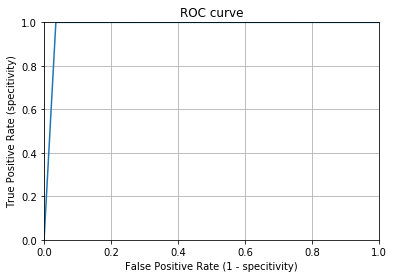

In [41]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(predict["tipped"],predict["prediction"])
plt.plot(fpr, tpr)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1 - specitivity)')
plt.ylabel('True Positive Rate (specitivity)')
plt.grid(True)

## (For Reference) Load a saved pipeline model and evaluate it on a data set

If you did save a model as suggested in the beginning of the workbook, you can load it again.

In [ ]:
from pyspark.ml import PipelineModel

saved_model = PipelineModel.load("s3://[[your-s3-bucket]]/model_location/")
test = spark.read.parquet("s3://[[your-s3-bucket]]/data_location/")

predictions = saved_model.transform(test)
prediction_and_labels = predictions.select("label","prediction").rdd

metrics = BinaryClassificationMetrics(prediction_and_labels)
print("Area under ROC = %s" % metrics.areaUnderROC)